In [1]:
# # Chapter 13 - Parallelizing Neural Network Training with TensorFlow

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
# ## 13.1. Building, compiling, and running machine learning models with TensorFlow

In [4]:
# ### 13.1.1. Performance challenges of expensive computations

In [5]:
# ### 13.1.2. What is TensorFlow?

In [6]:
# ### 13.1.3. First steps with TensorFlow

In [7]:
import tensorflow.compat.v1 as tf

## create a graph
g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')

    z = w*x + b
    init = tf.global_variables_initializer()

## create a session and pass in graph g
with tf.Session(graph=g) as sess:
    ## initialize w and b:
    sess.run(init)
    ## evaluate z:
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f --> z=%4.1f'%(
              t, sess.run(z, feed_dict={x:t})))

x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


In [8]:
with tf.Session(graph=g) as sess:
    sess.run(init)
    print(sess.run(z, feed_dict={x:[1., 2., 3.]}))

[2.7 4.7 6.7]


In [9]:
# ### 13.1.4. Working with array structures

In [10]:
import tensorflow.compat.v1 as tf
import numpy as np

g = tf.Graph()
with g.as_default():
    x = tf.placeholder(dtype=tf.float32,
                       shape=(None, 2, 3),
                       name='input_x')

    x2 = tf.reshape(x, shape=(-1, 6),
                    name='x2')

    ## calculate the sum of each column
    xsum = tf.reduce_sum(x2, axis=0, name='col_sum')

    ## calculate the mean of each column
    xmean = tf.reduce_mean(x2, axis=0, name='col_mean')

with tf.Session(graph=g) as sess:
    x_array = np.arange(18).reshape(3, 2, 3)
    print('input shape: ', x_array.shape)
    print('Reshaped:\n',
          sess.run(x2, feed_dict={x:x_array}))
    print('Column Sums:\n',
          sess.run(xsum, feed_dict={x:x_array}))
    print('Column Means:\n',
          sess.run(xmean, feed_dict={x:x_array}))

input shape:  (3, 2, 3)
Reshaped:
 [[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]]
Column Sums:
 [18. 21. 24. 27. 30. 33.]
Column Means:
 [ 6.  7.  8.  9. 10. 11.]


In [11]:
# ### 13.1.5. Developing a simple model with low-level TensorFlow API

In [12]:
import tensorflow.compat.v1 as tf
import numpy as np
 
X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1,
                    2.0, 5.0, 6.3,
                    6.6, 7.4, 8.0,
                    9.0])

In [13]:
class TfLinreg(object):

    def __init__(self, x_dim, learning_rate=0.01,
                 random_seed=None):
        self.x_dim = x_dim
        self.learning_rate = learning_rate
        self.g = tf.Graph()
        ## build the model
        with self.g.as_default():
            ## set graph-level random-seed
            tf.set_random_seed(random_seed)

            self.build()
            ## create initializer
            self.init_op = tf.global_variables_initializer()

    def build(self):
        ## define placeholders for inputs
        self.X = tf.placeholder(dtype=tf.float32,
                                shape=(None, self.x_dim),
                                name='x_input')
        self.y = tf.placeholder(dtype=tf.float32,
                                shape=(None),
                                name='y_input')
        print(self.X)
        print(self.y)
        ## define weight matrix and bias vector
        w = tf.Variable(tf.zeros(shape=(1)),
                        name='weight')
        b = tf.Variable(tf.zeros(shape=(1)), 
                        name="bias")
        print(w)
        print(b)

        self.z_net = tf.squeeze(w*self.X + b,
                                name='z_net')
        print(self.z_net)
        
        sqr_errors = tf.square(self.y - self.z_net,
                               name='sqr_errors')
        print(sqr_errors)
        self.mean_cost = tf.reduce_mean(sqr_errors,
                                        name='mean_cost')
        
        optimizer = tf.train.GradientDescentOptimizer(
                    learning_rate=self.learning_rate, 
                    name='GradientDescent')
        self.optimizer = optimizer.minimize(self.mean_cost)

In [14]:
lrmodel = TfLinreg(x_dim=X_train.shape[1], learning_rate=0.01)

Tensor("x_input:0", shape=(None, 1), dtype=float32)
Tensor("y_input:0", dtype=float32)
<tf.Variable 'weight:0' shape=(1,) dtype=float32>
<tf.Variable 'bias:0' shape=(1,) dtype=float32>
Tensor("z_net:0", dtype=float32)
Tensor("sqr_errors:0", dtype=float32)


In [15]:
def train_linreg(sess, model, X_train, y_train, num_epochs=10):
    ## initialiaze all variables: W & b
    sess.run(model.init_op)

    training_costs = []
    for i in range(num_epochs):
        _, cost = sess.run([model.optimizer, model.mean_cost],
                           feed_dict={model.X:X_train,
                                      model.y:y_train})
        training_costs.append(cost)

    return training_costs

In [16]:
sess = tf.Session(graph=lrmodel.g)
training_costs = train_linreg(sess, lrmodel, X_train, y_train)

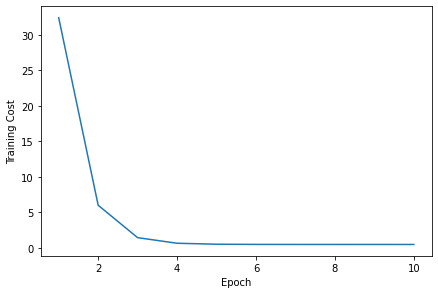

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

In [18]:
def predict_linreg(sess, model, X_test):
    y_pred = sess.run(model.z_net,
                      feed_dict={model.X:X_test})
    return y_pred

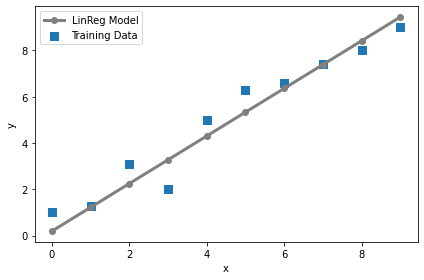

In [19]:
plt.scatter(X_train, y_train,
            marker='s', s=50,
            label='Training Data')
plt.plot(range(X_train.shape[0]),
         predict_linreg(sess, lrmodel, X_train),
         color='gray', marker='o',
         markersize=6, linewidth=3,
         label='LinReg Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# ## 13.2. Training neural networks efficiently with high-level TensorFlow APIs

In [21]:
# ### 13.2.1. Building multilayer neural networks using TensorFlow's Layers API

In [22]:
# unzips mnist

import sys
import gzip
import shutil
import os

if (sys.version_info > (3, 0)):
    writemode = 'wb'
else:
    writemode = 'w'

zipped_mnist = [f for f in os.listdir('./') if f.endswith('ubyte.gz')]
for z in zipped_mnist:
    with gzip.GzipFile(z, mode='rb') as decompressed, open(z[:-3], writemode) as outfile:
        outfile.write(decompressed.read())

In [23]:
import struct
 
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2

    return images, labels

In [24]:
## loading the data
X_train, y_train = load_mnist('.', kind='train')
print('Rows: %d,  Columns: %d' %(X_train.shape[0],
                                 X_train.shape[1]))

X_test, y_test = load_mnist('.', kind='t10k')
print('Rows: %d,  Columns: %d' %(X_test.shape[0],
                                     X_test.shape[1]))
## mean centering and normalization:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val

del X_train, X_test

print(X_train_centered.shape, y_train.shape)

print(X_test_centered.shape, y_test.shape)

Rows: 60000,  Columns: 784
Rows: 10000,  Columns: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


In [25]:
import tensorflow.compat.v1 as tf

n_features = X_train_centered.shape[1]
n_classes = 10
random_seed = 123
np.random.seed(random_seed)

g = tf.Graph()
with g.as_default():
    tf.set_random_seed(random_seed)
    tf_x = tf.placeholder(dtype=tf.float32,
                       shape=(None, n_features),
                       name='tf_x')

    tf_y = tf.placeholder(dtype=tf.int32,
                        shape=None, name='tf_y')
    y_onehot = tf.one_hot(indices=tf_y, depth=n_classes)

    h1 = tf.layers.dense(inputs=tf_x, units=50,
                         activation=tf.tanh,
                         name='layer1')

    h2 = tf.layers.dense(inputs=h1, units=50,
                         activation=tf.tanh,
                         name='layer2')

    logits = tf.layers.dense(inputs=h2,
                             units=10,
                             activation=None,
                             name='layer3')

    predictions = {
        'classes' : tf.argmax(logits, axis=1,
                              name='predicted_classes'),
        'probabilities' : tf.nn.softmax(logits,
                              name='softmax_tensor')
    }

In [26]:
## define cost function and optimizer:
with g.as_default():
    cost = tf.losses.softmax_cross_entropy(
            onehot_labels=y_onehot, logits=logits)

    optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=0.001)

    train_op = optimizer.minimize(loss=cost)

    init_op = tf.global_variables_initializer()

In [27]:
def create_batch_generator(X, y, batch_size=128, shuffle=False):
    X_copy = np.array(X)
    y_copy = np.array(y)

    if shuffle:
        data = np.column_stack((X_copy, y_copy))
        np.random.shuffle(data)
        X_copy = data[:, :-1]
        y_copy = data[:, -1].astype(int)

    for i in range(0, X.shape[0], batch_size):
        yield (X_copy[i:i+batch_size, :], y_copy[i:i+batch_size])

In [28]:
## create a session to launch the graph
sess =  tf.Session(graph=g)
## run the variable initialization operator
sess.run(init_op)

## 50 epochs of training:
training_costs = []
for epoch in range(50):
    training_loss = []
    batch_generator = create_batch_generator(
            X_train_centered, y_train,
            batch_size=64)
    for batch_X, batch_y in batch_generator:
        ## prepare a dict to feed data to our network:
        feed = {tf_x:batch_X, tf_y:batch_y}
        _, batch_cost = sess.run([train_op, cost],
                                 feed_dict=feed)
        training_costs.append(batch_cost)
    print(' -- Epoch %2d  '
          'Avg. Training Loss: %.4f' % (
              epoch+1, np.mean(training_costs)
    ))

 -- Epoch  1  Avg. Training Loss: 1.5422
 -- Epoch  2  Avg. Training Loss: 1.2274
 -- Epoch  3  Avg. Training Loss: 1.0571
 -- Epoch  4  Avg. Training Loss: 0.9458
 -- Epoch  5  Avg. Training Loss: 0.8659
 -- Epoch  6  Avg. Training Loss: 0.8051
 -- Epoch  7  Avg. Training Loss: 0.7567
 -- Epoch  8  Avg. Training Loss: 0.7171
 -- Epoch  9  Avg. Training Loss: 0.6840
 -- Epoch 10  Avg. Training Loss: 0.6557
 -- Epoch 11  Avg. Training Loss: 0.6313
 -- Epoch 12  Avg. Training Loss: 0.6098
 -- Epoch 13  Avg. Training Loss: 0.5907
 -- Epoch 14  Avg. Training Loss: 0.5737
 -- Epoch 15  Avg. Training Loss: 0.5583
 -- Epoch 16  Avg. Training Loss: 0.5444
 -- Epoch 17  Avg. Training Loss: 0.5316
 -- Epoch 18  Avg. Training Loss: 0.5199
 -- Epoch 19  Avg. Training Loss: 0.5091
 -- Epoch 20  Avg. Training Loss: 0.4990
 -- Epoch 21  Avg. Training Loss: 0.4897
 -- Epoch 22  Avg. Training Loss: 0.4810
 -- Epoch 23  Avg. Training Loss: 0.4728
 -- Epoch 24  Avg. Training Loss: 0.4651
 -- Epoch 25  Av

In [29]:
## do prediction on the test set:
feed = {tf_x : X_test_centered}
y_pred = sess.run(predictions['classes'],
                  feed_dict=feed)

print('Test Accuracy: %.2f%%' % (
      100*np.sum(y_pred == y_test)/y_test.shape[0]))

Test Accuracy: 93.61%


In [30]:
# ### 13.2.2. Developing Multilayer Neural Networks with Keras

In [31]:
X_train, y_train = load_mnist('./', kind='train')
print('Rows: %d,  Columns: %d' %(X_train.shape[0],
                                 X_train.shape[1]))
X_test, y_test = load_mnist('./', kind='t10k')
print('Rows: %d,  Columns: %d' %(X_test.shape[0],
                                 X_test.shape[1]))

## mean centering and normalization:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val
 
del X_train, X_test
 
print(X_train_centered.shape, y_train.shape)

print(X_test_centered.shape, y_test.shape)

Rows: 60000,  Columns: 784
Rows: 10000,  Columns: 784
(60000, 784) (60000,)
(10000, 784) (10000,)


In [32]:
import tensorflow.compat.v1 as tf
import tensorflow.keras as keras

# NOTE:
# ================================================
# If you have TensorFlow v1.3 installed
# you can use the keras API by
# importing it from the contrib module
# `import tensorflow.contrib.keras as keras`

np.random.seed(123)
tf.set_random_seed(123)

In [33]:
y_train_onehot = keras.utils.to_categorical(y_train)
 
print('First 3 labels: ', y_train[:3])
print('\nFirst 3 labels (one-hot):\n', y_train_onehot[:3])

First 3 labels:  [5 0 4]

First 3 labels (one-hot):
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [34]:
model = keras.models.Sequential()

model.add(
    keras.layers.Dense(
        units=50,
        input_dim=X_train_centered.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(
    keras.layers.Dense(
        units=50,
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(
    keras.layers.Dense(
        units=y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='softmax'))


sgd_optimizer = keras.optimizers.SGD(
        lr=0.001, decay=1e-7, momentum=.9)

model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy')

In [35]:
history = model.fit(X_train_centered, y_train_onehot,
                    batch_size=64, epochs=50,
                    verbose=1,
                    validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 62us/sample - loss: 0.7322 - val_loss: 0.3657
Epoch 2/50
54000/54000 [==============================] - 3s 57us/sample - loss: 0.3731 - val_loss: 0.2787
Epoch 3/50
54000/54000 [==============================] - 4s 76us/sample - loss: 0.3063 - val_loss: 0.2408
Epoch 4/50
54000/54000 [==============================] - 4s 76us/sample - loss: 0.2691 - val_loss: 0.2180
Epoch 5/50
54000/54000 [==============================] - 3s 64us/sample - loss: 0.2433 - val_loss: 0.2009
Epoch 6/50
54000/54000 [==============================] - 3s 64us/sample - loss: 0.2235 - val_loss: 0.1879
Epoch 7/50
54000/54000 [==============================] - 3s 63us/sample - loss: 0.2074 - val_loss: 0.1786
Epoch 8/50
54000/54000 [==============================] - 3s 62us/sample - loss: 0.1942 - val_loss: 0.1699
Epoch 9/50
54000/54000 [==============================] - 3s 60us/sample - loss: 0.1828 - val_l

In [36]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
print('First 3 predictions: ', y_train_pred[:3])

First 3 predictions:  [5 0 4]


In [37]:
y_train_pred = model.predict_classes(X_train_centered,
                                     verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]

print('First 3 predictions: ', y_train_pred[:3])
print('Training accuracy: %.2f%%' % (train_acc * 100))

First 3 predictions:  [5 0 4]
Training accuracy: 98.91%


In [38]:
y_test_pred = model.predict_classes(X_test_centered,
                                    verbose=0)

correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print('Test accuracy: %.2f%%' % (test_acc * 100))

Test accuracy: 96.33%


In [39]:
# ## 13.3. Choosing activation functions for multilayer networks

In [40]:
# ### 13.3.1. Logistic function recap

In [41]:
import numpy as np

X = np.array([1, 1.4, 2.5]) ## first value must be 1
w = np.array([0.4, 0.3, 0.5])

def net_input(X, w):
    return np.dot(X, w)

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_activation(X, w):
    z = net_input(X, w)
    return logistic(z)

print('P(y=1|x) = %.3f' % logistic_activation(X, w))

P(y=1|x) = 0.888


In [42]:
# W : array with shape = (n_output_units, n_hidden_units+1)
#     note that the first column are the bias units

W = np.array([[1.1, 1.2, 0.8, 0.4],
              [0.2, 0.4, 1.0, 0.2],
              [0.6, 1.5, 1.2, 0.7]])

# A : data array with shape = (n_hidden_units + 1, n_samples)
#     note that the first column of this array must be 1

A = np.array([[1, 0.1, 0.4, 0.6]])

Z = np.dot(W, A[0])
y_probas = logistic(Z)

print('Net Input: \n', Z)

print('Output Units:\n', y_probas)

Net Input: 
 [1.78 0.76 1.65]
Output Units:
 [0.85569687 0.68135373 0.83889105]


In [43]:
y_class = np.argmax(Z, axis=0)
print('Predicted class label: %d' % y_class)

Predicted class label: 0


In [44]:
# ### 13.3.2. Estimating class probabilities in multi-class classification via the softmax function

In [45]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z))

y_probas = softmax(Z)
print('Probabilities:\n', y_probas)

Probabilities:
 [0.44668973 0.16107406 0.39223621]


In [46]:
np.sum(y_probas)

1.0

In [47]:
# ### 13.3.3. Broadening the output spectrum by using a hyperbolic tangent

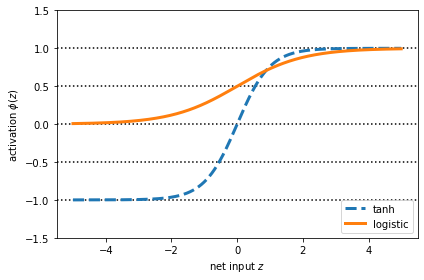

In [48]:
import matplotlib.pyplot as plt

def tanh(z):
    e_p = np.exp(z)
    e_m = np.exp(-z)
    return (e_p - e_m) / (e_p + e_m)

z = np.arange(-5, 5, 0.005)
log_act = logistic(z)
tanh_act = tanh(z)

plt.ylim([-1.5, 1.5])
plt.xlabel('net input $z$')
plt.ylabel('activation $\phi(z)$')
plt.axhline(1, color='black', linestyle=':')
plt.axhline(0.5, color='black', linestyle=':')
plt.axhline(0, color='black', linestyle=':')
plt.axhline(-0.5, color='black', linestyle=':')
plt.axhline(-1, color='black', linestyle=':')

plt.plot(z, tanh_act,
         linewidth=3, linestyle='--',
         label='tanh')

plt.plot(z, log_act,
         linewidth=3,
         label='logistic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [49]:
# ### 13.3.4. Rectified Linear Unit activation